In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate
from src.interpolate import *
from src.emfiles import get_data_from_df
import jax

from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
import mrcfile

from external.cryojax.JEM3 import api01 as jem3api01
plt.rcParams["figure.figsize"]=8,8



In [2]:
files_base =  "/gpfs/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
files_star_in = "job550_particles_roy10k.star"

### Cryojax

In [3]:
rawdat = jem3api01.raw_images_class()
rawdat.starloader(files_base,files_star_in, threads=4)

read_star_mrcs: load star
read_star_mrcs: sort star
read_star_mrcs: group star by mrc file
read_star_mrcs: number of particles: 9972
read_star_mrcs: Computed size is 0.831000 A
read_star_mrcs: grouping particles by output stack


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:532: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_NAME].str.split("@").str
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:540: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_ORIGINAL_NAME].str.split("@").str


read_star_mrcs: convert parameters time:  7.839405059814453
read_star_mrcs: reading images... 
read_star_mrcs: read images time:  19.90697693824768
read_star_mrcs: compute fft2...
read_star_mrcs: fft time:  9.543575048446655
read_star_mrcs: images_array.shape: (9972, 308, 308)
read_star_mrcs: len(images_array): 9972
raw_images_class: starloader: full frequency radius (a.k.a. Nyquist): 0.597777673589948


### My code

In [4]:
df = star.parse_star(files_base + files_star_in, keep_index = False)
imgs, pixel_size, angles, shifts, ctf_params = get_data_from_df(df, files_base)


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:532: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_NAME].str.split("@").str
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:540: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_ORIGINAL_NAME].str.split("@").str


In [5]:
imgs_f = [np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img))) for img in imgs]

In [6]:
imgs_f = np.array(imgs_f)

In [7]:
print(imgs_f.shape)
print(rawdat.images_fft.shape)

(9972, 308, 308)
(9972, 308, 308)


In [8]:
angles_rev = [ang[::-1] for ang in angles]
ma = angles_rev- rawdat.images_var['a']
np.sum(np.abs(ma))

0.0

In [9]:
np.sum(np.abs(rawdat.images_var['organgst'] - shifts))

0.0

In [10]:
print(ctf_params.shape)
print(rawdat.images_var['ctf'].shape)

(9972, 9)
(9972, 8)


In [11]:
np.sum(np.abs(ctf_params[:,:8] - rawdat.images_var['ctf']))

0.0

In [12]:
rawdat.image_sstep

0.831

In [13]:
np.sum(pixel_size-rawdat.image_sstep)

0.0

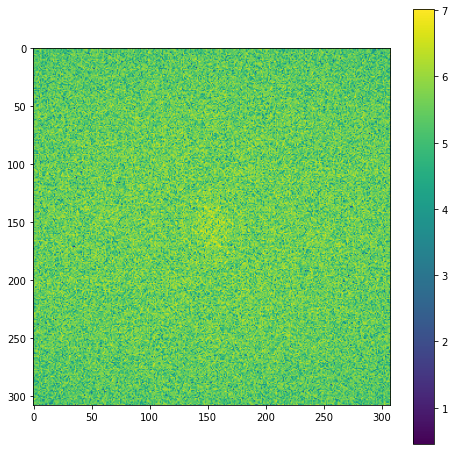

In [20]:
plt.imshow((np.log(np.abs(imgs_f[0])))); plt.colorbar()

In [21]:
dd = (np.abs(imgs_f[0] -np.fft.fftshift(rawdat.images_fft[0])))

In [22]:
np.max(np.abs(dd))

0.00017254109954768117

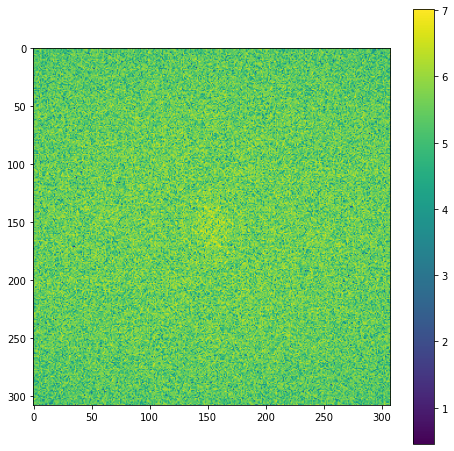

In [23]:
plt.imshow(np.fft.fftshift(np.log(np.abs(rawdat.images_fft[0])))); plt.colorbar()

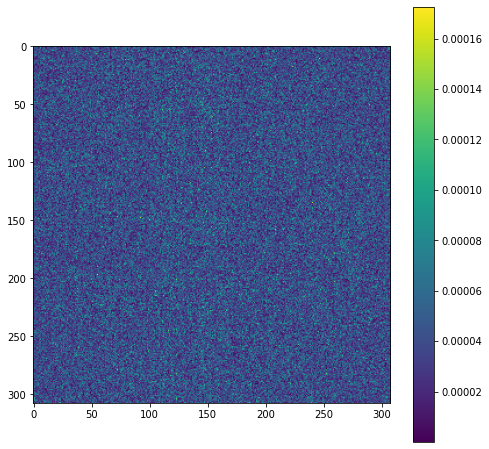

In [24]:
plt.imshow(np.abs(imgs_f[0]- np.fft.fftshift(rawdat.images_fft[0]))); plt.colorbar()